In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import ADASYN
from tqdm import tqdm
import pickle 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.metrics import accuracy_score


In [3]:
data = pd.read_csv("C:\\Users\\Alluri\\Downloads\\Deploy\\diabetes.csv")
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
data_y = pd.DataFrame(data = data['Outcome'],columns=['Outcome'])
data_x = data.drop(columns="Outcome")

In [7]:
data_x.columns

data_y.columns

Index(['Outcome'], dtype='object')

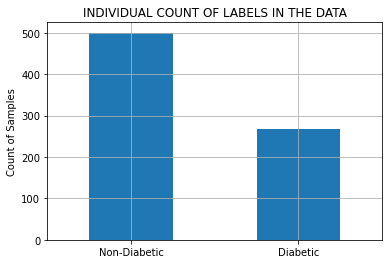

In [8]:
ata_y['Outcome'].value_counts().plot(kind='bar')
plt.title("INDIVIDUAL COUNT OF LABELS IN THE DATA")
plt.grid()
plt.xticks([0, 1],["Non-Diabetic","Diabetic"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()

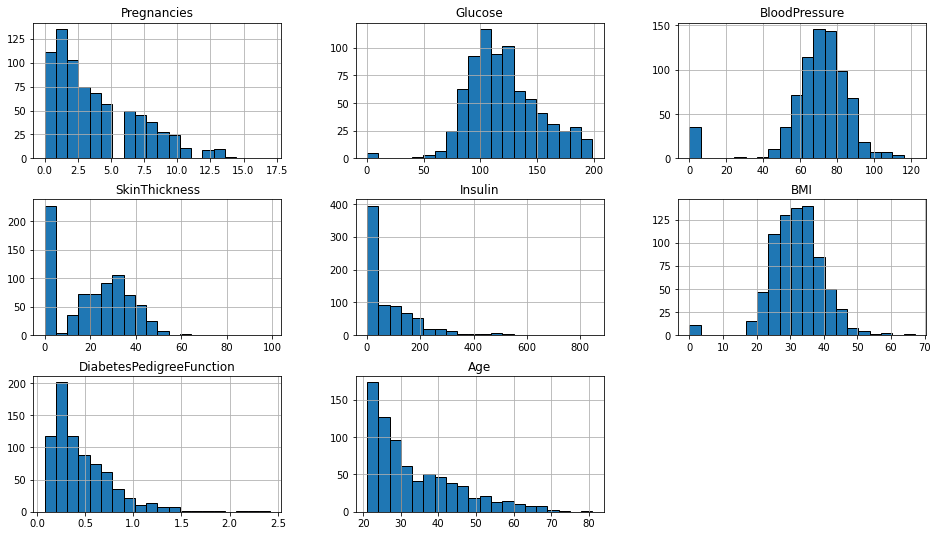

In [9]:
data_x.hist(figsize=(16,9), edgecolor="black", bins=20)
plt.show()

In [10]:
def imputation(data,feature):
  median = data[feature].median()
  print("median of "+str(feature)+"::"+str(median))
  data = data.replace({feature:0},median)
  return data

In [11]:
data = imputation(data,"BloodPressure")
data = imputation(data,"Glucose")
data = imputation(data,"SkinThickness")
data = imputation(data,"Insulin")
## we can still see zeroes in insulin even after imputation for diabetic samples..so we can roughly conclude that diabetics have very low insulin levels..
data = imputation(data,"BMI")


median of BloodPressure::72.0
median of Glucose::117.0
median of SkinThickness::23.0
median of Insulin::30.5
median of BMI::32.0


In [12]:
def Univar_analysis(data,feature):
  data_nd = data.loc[data["Outcome"]==0] 
  data_d = data.loc[data["Outcome"]==1] 
  sb.set_style("whitegrid") 
  plt.xlabel(feature)
  plt.plot(data_nd[feature],np.zeros_like(data_nd[feature]),marker="x",label='Non-Diabetic',color='red') ## zeros_like will simply create zeros with length same as x cordinate.. 
  plt.plot(data_d[feature],np.zeros_like(data_d[feature]),marker="+",label='Diabetic',color='green') 
  plt.legend()
  plt.title("1-D Scatter plot on feature "+feature)
  plt.show()

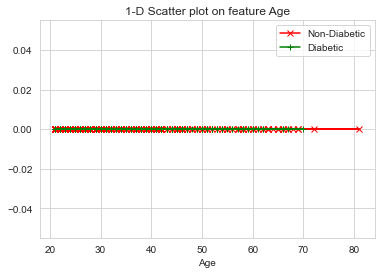

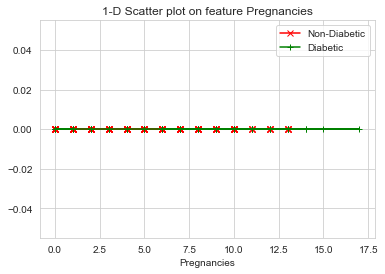

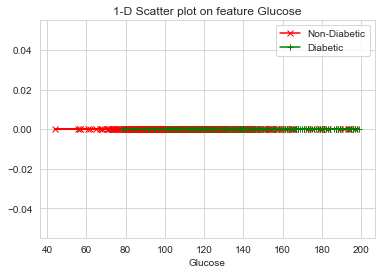

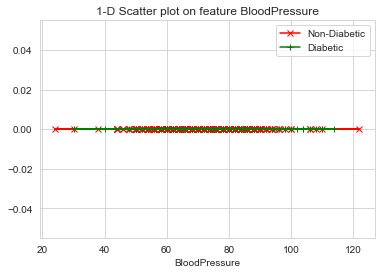

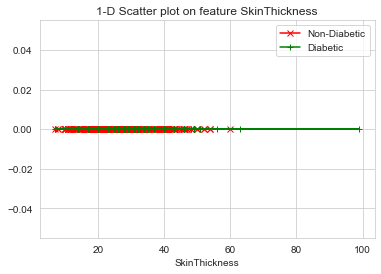

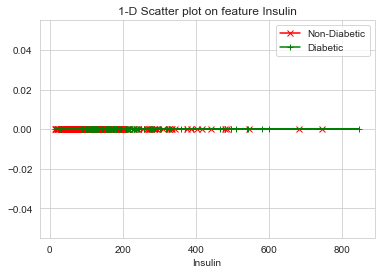

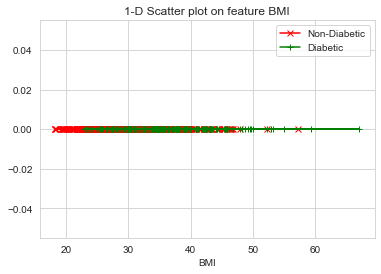

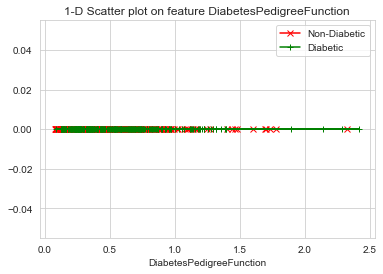

In [13]:
Univar_analysis(data,"Age")

Univar_analysis(data,"Pregnancies")

Univar_analysis(data,"Glucose")

Univar_analysis(data,"BloodPressure")

Univar_analysis(data,"SkinThickness")

Univar_analysis(data,"Insulin")

Univar_analysis(data,"BMI")

Univar_analysis(data,"DiabetesPedigreeFunction")

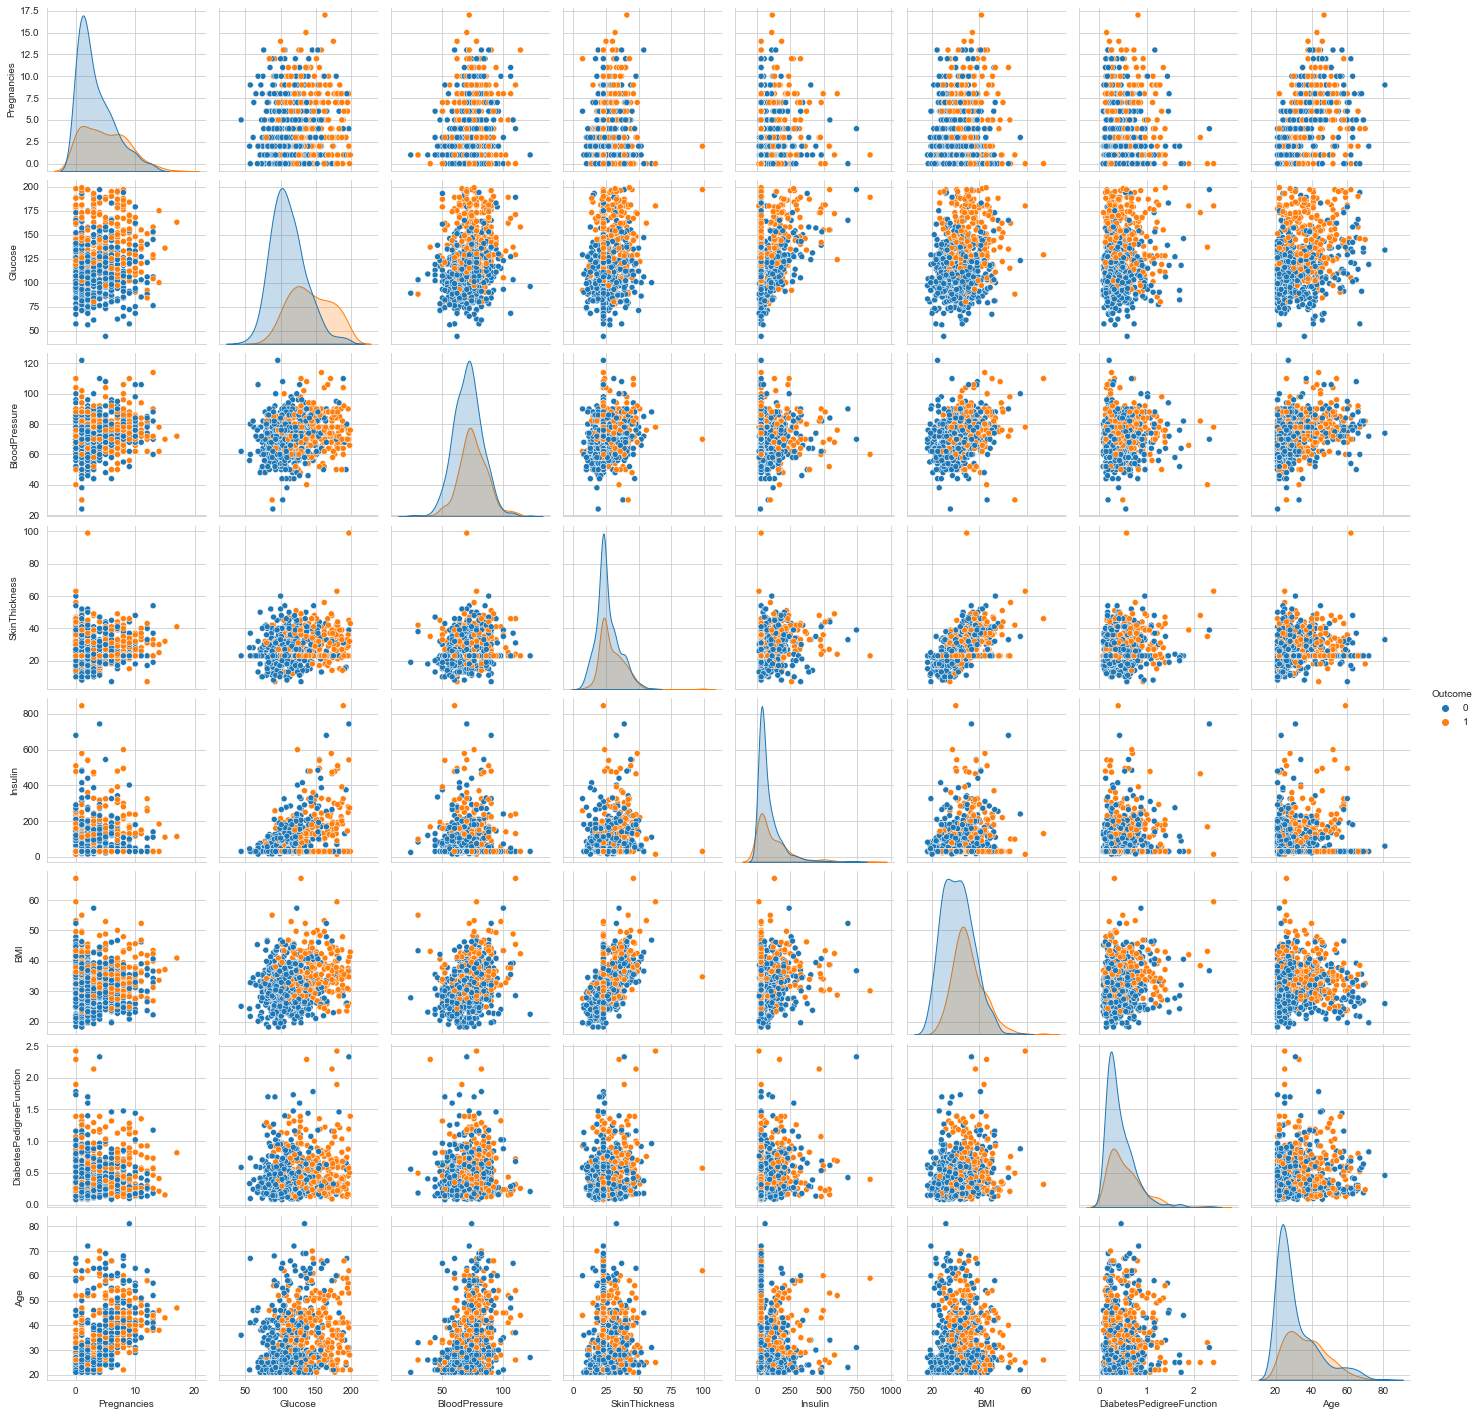

In [14]:
sb.pairplot(data,hue="Outcome")
plt.show()

SHAPE OF X-TRAIN:: (537, 8)
SHAPE OF Y-TRAIN:: (537, 1)
SHAPE OF X-TEST:: (231, 8)
SHAPE OF Y-TEST:: (231, 1)


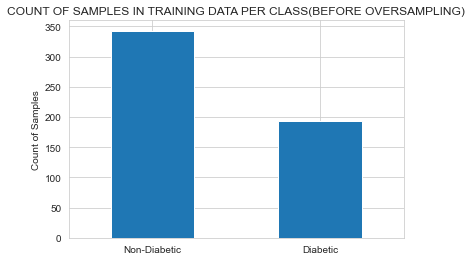

In [15]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.70,random_state=0)#45
print("SHAPE OF X-TRAIN::",x_train.shape)
print("SHAPE OF Y-TRAIN::",y_train.shape)
print("SHAPE OF X-TEST::",x_test.shape)
print("SHAPE OF Y-TEST::",y_test.shape)
y_train['Outcome'].value_counts().plot(kind='bar')
plt.title("COUNT OF SAMPLES IN TRAINING DATA PER CLASS(BEFORE OVERSAMPLING)")
plt.xticks([0, 1],["Non-Diabetic","Diabetic"],rotation=360)
plt.ylabel("Count of Samples")
plt.show()

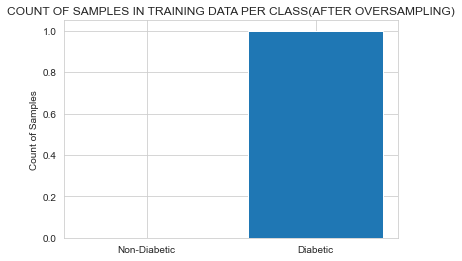

In [16]:
oversample = ADASYN(random_state=10,sampling_strategy="minority")
x_train_os, y_train_os = oversample.fit_sample(x_train,y_train)
dict_={"Non-Diabetic":0,"Diabetic":0}
for i in y_train_os:
  if(i==0):
    dict_['Non-Diabetic']+=1
  else:
    dict_['Diabetic']+=1
plt.bar(*zip(*dict_.items()))
plt.title("COUNT OF SAMPLES IN TRAINING DATA PER CLASS(AFTER OVERSAMPLING)")
plt.ylabel("Count of Samples")
plt.show()

In [17]:
scale = StandardScaler()
x_train_std = scale.fit_transform(x_train_os)
x_test_std = scale.transform(x_test)

In [19]:
print(scale.mean_)

[  3.87317784 122.83819242  70.17055394  21.44606414  88.11953353
  32.79453439   0.48222985  33.99708455]


In [22]:
x_test_std[1]

def scale_data(array):
    means = np.array([  4.061425  , 122.98923755,  70.26122953,  21.45881463,88.24362615,  32.70515732,   0.48941921,  34.41192381])
    stds=   np.array([11.4233741,975.386508,349.351072, 250.185968,14964.9958,57.4279121,.110725199, 136.299159]) **0.5
    return (array-means)/stds
scale_data(np.array([2.0,107.0,74.0,30.0,100.6,33.6,0.40399999999999997,23.0]).reshape(1,8))


array([[-0.60991644, -0.51196395,  0.20003121,  0.53999119,  0.10100729,
         0.1180824 , -0.25670381, -0.97748989]])

In [23]:
scoring  = ["accuracy","precision","recall","f1_macro"]
n_estm_list=[]
for i in range(1,200):
  n_estm_list.append(i)
parameters = {'n_estimators':n_estm_list}
rand_forest = RandomForestClassifier(random_state=10)
clf = GridSearchCV(rand_forest,parameters,cv=5,refit="accuracy",scoring=scoring)
clf.fit(x_train_std, y_train_os)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1_macro'])

In [24]:
clf.best_estimator_


RandomForestClassifier(n_estimators=15, random_state=10)

In [25]:
cv_prec = clf.cv_results_['mean_test_precision']
cv_recall = clf.cv_results_['mean_test_recall']
cv_fscore = clf.cv_results_['mean_test_f1_macro']
cv_accs = clf.cv_results_['mean_test_accuracy']


In [27]:
prec_index = np.where(cv_prec==max(cv_prec))
try:
  print("Obtained maximum  precision when number of estimators=",prec_index[0].item()+1)
except:
  print("Obtained maximum  precision when number of estimators=",prec_index.item()+1)
recall_index = np.where(cv_recall==max(cv_recall))
try:
  print("Obtained maximum  recall when number of estimators=",recall_index[0][0].item()+1)
except:
  print("Obtained maximum  recall when number of estimators=",recall_index.item()+1)  
f1score_index = np.where(cv_fscore==max(cv_fscore))
try:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0].item()+1)
except:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0]+1)
acc_index = np.where(cv_accs==max(cv_accs))
try:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0].item()+1)
except:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0]+1)

Obtained maximum  precision when number of estimators= 15
Obtained maximum  recall when number of estimators= 37
Obtained maximum  f1-score when number of estimators= 15
Obtained maximum  accuracy when number of estimators= 15


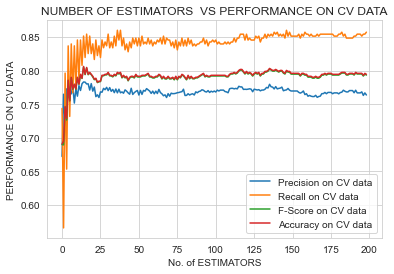

In [28]:
plt.plot(cv_prec,label="Precision on CV data")
plt.plot(cv_recall,label= "Recall on CV data")
plt.plot(cv_fscore,label = "F-Score on CV data")
plt.plot(cv_accs,label = "Accuracy on CV data")
plt.xlabel("No. of ESTIMATORS")
plt.ylabel("PERFORMANCE ON CV DATA")
plt.title("NUMBER OF ESTIMATORS  VS PERFORMANCE ON CV DATA")
plt.legend()
plt.grid(linestyle='-')
plt.show()

In [32]:

#Random Forest

rand_forest = RandomForestClassifier(n_estimators=181,random_state=10)
rand_forest.fit(x_train_std, y_train_os)
y_pred = rand_forest.predict(x_test_std)
print("Accuracy on test data using random-forest classifier::",rand_forest.score(x_test_std, y_test)*100)
print("Precision on test data using random-forest classifier::",precision_score(y_test, y_pred, average="macro"))
print("Recall on test data using random-forest classifier::",recall_score(y_test, y_pred, average="macro"))
print("F-Score on test data using random-forest classifier::",f1_score(y_test, y_pred, average="macro"))
spec = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[1][1])
print("Specificity on test data using random-forest classifier::",spec)

Accuracy on test data using random-forest classifier:: 77.92207792207793
Precision on test data using random-forest classifier:: 0.7467532467532467
Recall on test data using random-forest classifier:: 0.751850576691341
F-Score on test data using random-forest classifier:: 0.7491322586827367
Specificity on test data using random-forest classifier:: 0.6493506493506493


In [33]:
pickle_out = open("C:\\Users\\Alluri\\Downloads\\Deploy\\randforest.pickle","wb")
pickle.dump(rand_forest, pickle_out)

In [31]:
#AdaBoost Classifier

n_estm_list_adaboost=[]
scoring  = ["accuracy","precision","recall","f1_macro"]
for i in range(1,400):
  n_estm_list_adaboost.append(i)
parameters_adaboost = {'n_estimators':n_estm_list_adaboost}
ada_boost = AdaBoostClassifier(random_state=10)
clf = GridSearchCV(ada_boost,parameters_adaboost,cv=5,refit="accuracy",scoring=scoring)
clf.fit(x_train_std, y_train_os)

clf.best_estimator_

AdaBoostClassifier(n_estimators=45, random_state=10)

In [34]:
cv_prec_adaboost = clf.cv_results_['mean_test_precision']
cv_recall_adaboost = clf.cv_results_['mean_test_recall']
cv_fscore_adaboost = clf.cv_results_['mean_test_f1_macro']
cv_accs_adaboost = clf.cv_results_['mean_test_accuracy']

In [35]:
prec_index = np.where(cv_prec_adaboost==max(cv_prec_adaboost))
try:
  print("Obtained maximum  precision when number of estimators=",prec_index[0].item()+1)
except:
  print("Obtained maximum  precision when number of estimators=",prec_index[0]+1)
recall_index = np.where(cv_recall_adaboost==max(cv_recall_adaboost))
try:
  print("Obtained maximum  recall when number of estimators=",recall_index[0][0].item()+1)
except:
  print("Obtained maximum  recall when number of estimators=",recall_index.item()+1)
f1score_index = np.where(cv_fscore_adaboost==max(cv_fscore_adaboost))
try:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0].item()+1)
except:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0]+1)
acc_index = np.where(cv_accs_adaboost==max(cv_accs_adaboost))
try:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0].item()+1)
except:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0]+1)

Obtained maximum  precision when number of estimators= 44
Obtained maximum  recall when number of estimators= 7
Obtained maximum  f1-score when number of estimators= 45
Obtained maximum  accuracy when number of estimators= [45 46]


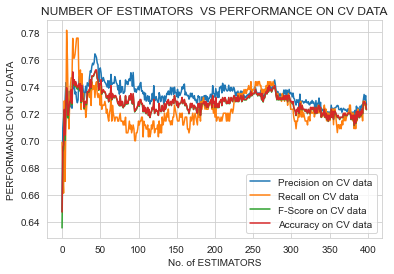

In [36]:
plt.plot(cv_prec_adaboost,label="Precision on CV data")
plt.plot(cv_recall_adaboost,label="Recall on CV data")
plt.plot(cv_fscore_adaboost,label="F-Score on CV data")
plt.plot(cv_accs_adaboost,label="Accuracy on CV data")
plt.xlabel("No. of ESTIMATORS")
plt.ylabel("PERFORMANCE ON CV DATA")
plt.title("NUMBER OF ESTIMATORS  VS PERFORMANCE ON CV DATA")
plt.legend()
plt.grid(linestyle='-')
plt.show()

In [37]:
ada_boost = AdaBoostClassifier(n_estimators=74, random_state=10)
ada_boost.fit(x_train_std, y_train_os)
y_pred = ada_boost.predict(x_test_std)
print("Accuracy on test data using adaboost classifier::",ada_boost.score(x_test_std, y_test)*100)
print("Precision on test data using adaboost classifier::",precision_score(y_test, y_pred, average="macro"))
print("Recall on test data using adaboost classifier::",recall_score(y_test, y_pred, average="macro"))
print("F-Score on test data using adaboost classifier::",f1_score(y_test, y_pred, average="macro"))
spec = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[1][1])
print("Specificity on test data using adaboost classifier::",spec)

Accuracy on test data using adaboost classifier:: 73.16017316017316
Precision on test data using adaboost classifier:: 0.695981339008021
Recall on test data using adaboost classifier:: 0.7061025994147013
F-Score on test data using adaboost classifier:: 0.6999748617395676
Specificity on test data using adaboost classifier:: 0.573170731707317


In [38]:
pickle_out = open("C:\\Users\\Alluri\\Downloads\\Deploy\\AdaaBoost.pickle","wb")
pickle.dump(ada_boost, pickle_out)

In [39]:
#XGBOOST

n_estm_list_xgboost=[]
scoring  = ["accuracy","precision","recall","f1_macro"]
for i in range(1,401):
  n_estm_list_xgboost.append(i)
parameters_xgboost = {'n_estimators':n_estm_list_xgboost}
xg_boost = XGBClassifier(random_state=10)
clf = GridSearchCV(xg_boost,parameters_xgboost,cv=5,refit="accuracy",scoring=scoring)
clf.fit(x_train_std, y_train_os)

clf.best_estimator_

[19:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=112, n_jobs=4, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
cv_prec_xgboost = clf.cv_results_['mean_test_precision']
cv_recall_xgboost = clf.cv_results_['mean_test_recall']
cv_fscore_xgboost = clf.cv_results_['mean_test_f1_macro']
cv_accs_xgboost = clf.cv_results_['mean_test_accuracy']


In [41]:
prec_index = np.where(cv_prec_xgboost==max(cv_prec_xgboost))
try:
  print("Obtained maximum  precision when number of estimators=",prec_index[0].item()+1)
except:
  print("Obtained maximum  precision when number of estimators=",prec_index[0]+1)
recall_index = np.where(cv_recall_xgboost==max(cv_recall_xgboost))
try:
  print("Obtained maximum  recall when number of estimators=",recall_index[0][0].item()+1)
except:
  print("Obtained maximum  recall when number of estimators=",recall_index.item()+1)
f1score_index = np.where(cv_fscore_xgboost==max(cv_fscore_xgboost))
try:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0].item()+1)
except:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0]+1)
acc_index = np.where(cv_accs_xgboost==max(cv_accs_xgboost))
try:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0].item()+1)
except:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0]+1)

Obtained maximum  precision when number of estimators= 80
Obtained maximum  recall when number of estimators= 124
Obtained maximum  f1-score when number of estimators= 112
Obtained maximum  accuracy when number of estimators= 112


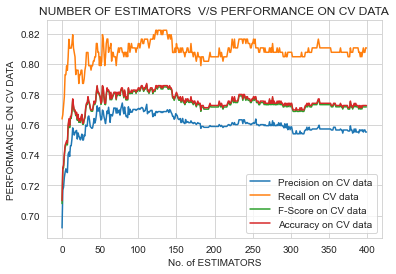

In [42]:
plt.plot(cv_prec_xgboost,label="Precision on CV data")
plt.plot(cv_recall_xgboost,label ="Recall on CV data")
plt.plot(cv_fscore_xgboost,label="F-Score on CV data")
plt.plot(cv_accs_xgboost,label="Accuracy on CV data")
plt.xlabel("No. of ESTIMATORS")
plt.ylabel("PERFORMANCE ON CV DATA")
plt.legend()
plt.title("NUMBER OF ESTIMATORS  V/S PERFORMANCE ON CV DATA")
plt.grid(linestyle="-")
plt.show()

In [43]:
xg_boost = XGBClassifier(n_estimators=62, random_state=10)
xg_boost.fit(x_train_std, y_train_os)
y_pred = xg_boost.predict(x_test_std)
print("Accuracy on test data using XGBoost Classifier::",xg_boost.score(x_test_std, y_test)*100)
print("Precision on test data using XGBoost Classifier::",precision_score(y_test, y_pred, average="macro"))
print("Recall on test data using XGBoost Classifier::",recall_score(y_test, y_pred, average="macro"))
print("F-Score on test data using XGBoost Classifier::",f1_score(y_test, y_pred, average="macro"))
spec = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[1][1])
print("Specificity on test data using XGBoost Classifier::",spec)

[20:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on test data using XGBoost Classifier:: 78.35497835497836
Precision on test data using XGBoost Classifier:: 0.7521523178807947
Recall on test data using XGBoost Classifier:: 0.7621793768290583
F-Score on test data using XGBoost Classifier:: 0.7564935064935064
Specificity on test data using XGBoost Classifier:: 0.65


In [47]:
pickle_out = open("C:\\Users\\Alluri\\Downloads\\Deploy\\XGBoost.pickle","wb")
pickle.dump(xg_boost, pickle_out)

In [48]:
#GradientBoost  

n_estm_list_gradboost=[]
scoring  = ["accuracy","precision","recall","f1_macro"]
for i in range(1,401):
  n_estm_list_gradboost.append(i)
parameters_gradboost = {'n_estimators':n_estm_list_gradboost}
grad_boost = GradientBoostingClassifier(learning_rate=0.09,random_state=10)
clf = GridSearchCV(grad_boost,parameters_gradboost,cv=5,refit="accuracy",scoring=scoring)
clf.fit(x_train_std, y_train_os)

clf.best_estimator_



GradientBoostingClassifier(learning_rate=0.09, n_estimators=77, random_state=10)

In [49]:
cv_prec_gradboost = clf.cv_results_['mean_test_precision']
cv_recall_gradboost = clf.cv_results_['mean_test_recall']
cv_fscore_gradboost = clf.cv_results_['mean_test_f1_macro']
cv_accs_gradboost = clf.cv_results_['mean_test_accuracy']

In [51]:
prec_index = np.where(cv_prec_gradboost==max(cv_prec_gradboost))
try:
  print("Obtained maximum  precision when number of estimators=",prec_index[0].item()+1)
except:
  print("Obtained maximum  precision when number of estimators=",prec_index[0]+1)
recall_index = np.where(cv_recall_gradboost==max(cv_recall_gradboost))
try:
  print("Obtained maximum  recall when number of estimators=",recall_index[0][0].item()+1)
except:
  print("Obtained maximum  recall when number of estimators=",recall_index.item()+1)
f1score_index = np.where(cv_fscore_gradboost==max(cv_fscore_gradboost))
try:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0].item()+1)
except:
  print("Obtained maximum  f1-score when number of estimators=",f1score_index[0]+1)
acc_index = np.where(cv_accs_gradboost==max(cv_accs_gradboost))
try:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0].item()+1)
except:
  print("Obtained maximum  accuracy when number of estimators=",acc_index[0]+1)


Obtained maximum  precision when number of estimators= 77
Obtained maximum  recall when number of estimators= 115
Obtained maximum  f1-score when number of estimators= 77
Obtained maximum  accuracy when number of estimators= 77


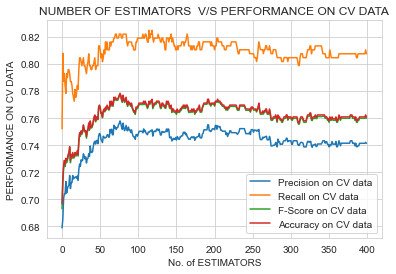

In [52]:
plt.plot(cv_prec_gradboost,label="Precision on CV data")
plt.plot(cv_recall_gradboost,label="Recall on CV data")
plt.plot(cv_fscore_gradboost,label="F-Score on CV data")
plt.plot(cv_accs_gradboost,label="Accuracy on CV data")
plt.xlabel("No. of ESTIMATORS")
plt.ylabel("PERFORMANCE ON CV DATA")
plt.title("NUMBER OF ESTIMATORS  V/S PERFORMANCE ON CV DATA")
plt.legend()
plt.grid(linestyle="-")
plt.show()

In [53]:
grad_boost = GradientBoostingClassifier(n_estimators=140,learning_rate=0.09,random_state=10)
grad_boost.fit(x_train_std, y_train_os)
y_pred = grad_boost.predict(x_test_std)
print("Accuracy on test data using Gradient-Boosting Classifier::",grad_boost.score(x_test_std, y_test)*100)
print("Precision on test data using Gradient-Boosting Classifier::",precision_score(y_test, y_pred, average="macro"))
print("Recall on test data using Gradient-Boosting Classifier::",recall_score(y_test, y_pred, average="macro"))
print("F-Score on test data using Gradient-Boosting Classifier::",f1_score(y_test, y_pred, average="macro"))
spec = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[1][1])
print("Specificity on test data using Gradient-Boosting Classifier::",spec)

Accuracy on test data using Gradient-Boosting Classifier:: 76.19047619047619
Precision on test data using Gradient-Boosting Classifier:: 0.7286419753086419
Recall on test data using Gradient-Boosting Classifier:: 0.7391117231881563
F-Score on test data using Gradient-Boosting Classifier:: 0.73300409793002
Specificity on test data using Gradient-Boosting Classifier:: 0.6172839506172839


In [67]:
pickle_out = open("C:\\Users\\Alluri\\Downloads\\Deploy\\GradientBoost.pickle","wb")
pickle.dump(grad_boost, pickle_out)


In [68]:
pickle_in = open("C:\\Users\\Alluri\\Downloads\\Deploy\\AdaaBoost.pickle","rb")
adaboost_ = pickle.load(pickle_in)

pickle_in = open("C:\\Users\\Alluri\\Downloads\\Deploy\\GradientBoost.pickle","rb")
gradboost_ = pickle.load(pickle_in)

pickle_in = open("C:\\Users\\Alluri\\Downloads\\Deploy\\randforest.pickle","rb")
randforest_ = pickle.load(pickle_in)

pickle_in = open("C:\\Users\\Alluri\\Downloads\\Deploy\\XGBoost.pickle","rb")
xgboost_ = pickle.load(pickle_in)

In [71]:
l1 = list(adaboost_.predict(x_test_std))
l2 = list(xgboost_.predict(x_test_std)) 
l3 = list(gradboost_.predict(x_test_std)) 
l4 = list(randforest_.predict(x_test_std)) 



In [72]:
#Voting Classifier

y_pred_vote = []
for i in range(len(l1)):
  y_pred_vote.append(mode([l2[i],l3[i],l4[i]]))
print("Accuracy on test data using Voting Classifier::",accuracy_score(y_test,y_pred_vote)*100)
print("Precision on test data using Voting Classifier::",precision_score(y_test, y_pred_vote, average="macro"))
print("Recall on test data using Voting Classifier::",recall_score(y_test, y_pred_vote, average="macro"))
print("F-Score on test data using Voting Classifier::",f1_score(y_test, y_pred_vote, average="macro"))
spec = confusion_matrix(y_test, y_pred_vote)[1][1]/(confusion_matrix(y_test,y_pred_vote)[0][1]+confusion_matrix(y_test, y_pred_vote)[1][1])
print("Specificity on test data using Voting Classifier::",spec)



Accuracy on test data using Voting Classifier:: 78.78787878787878
Precision on test data using Voting Classifier:: 0.7567455029980013
Recall on test data using Voting Classifier:: 0.7653640902048546
F-Score on test data using Voting Classifier:: 0.760581255155784
Specificity on test data using Voting Classifier:: 0.6582278481012658
